The purpose of the project is this course is for you to show what you have learnt. It is a bit more free that the assignments, we want you to show us that you can use Python to investigate a dataset. 

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

We are going to look at a different type of data, which is based on words, in this case song lyrics. 

Since the algorithms that we have seen all take as input some form of numerical vector, we will need to turn the words into numerical vectors. There are a few ways to do this, but the one we are going to use is call a Bag of Words. The reason for calling it a Bag is to suggest that the order of the words doesn't matter, just their frequency. Essentially, it counts how often each word gets used in each piece of text, and then the counts form the input vector. These counts are often normalised by the number of words in the text, since otherwise longer pieces get higher scores than short ones. 

The dataset we are going to use is a set of song lyrics. There is a zip file on Blackboard containing the lyrics of 80 songs (that Rolling Stone magazine decided were the most amazing songs there are) called `rs_lyrics.zip`. Download it and unzip it. It will make a folder called `rs_lyrics` with the songs inside. The following code will then read then in, and store the songtitle and lyrics in a dataframe.

In [116]:
import os
df = pd.DataFrame(columns = ["Name","Lyrics"])
i=0
for filename in os.listdir('rs_lyrics'):
   with open(os.path.join('rs_lyrics', filename), 'r') as f:
        df.loc[i] =[filename[:-4], f.read().splitlines()]
        df["Lyrics"][i] = " ".join(df["Lyrics"][i])
        i+=1
df.head()

,Name,Lyrics
0,1999,I was dreamin' when I wrote this Forgive me if...
1,all_apologies,What else should I be All apologies What else ...
2,anarchy_in_the_uk,I am an antichrist uh I am an anarchist Don't ...
3,a_day_in_the_life,I read the news today oh boy About a lucky man...
4,back_in_black,Back in black I hit the sack I've been too lon...


We have to do a lot of work before we can cluster word data. As the length of the vector is the number of different words in all of the texts, it can end up as a very long vector. So we want to 
- remove the unimportant words
- remove the short words
- remove the punctuation
- make everything lower-case, so that "Love" and "love" are the same word.

There are various ways doing all of these, but they aren't too hard to write yourself. To get single words in lower case from a string called `text` use `text.lower().strip().split()`
That sorts out the last of those four aims for us. 

For the third one, you can use `translate` from the `string` module. Use `import string` and then:
`text = text.translate(str.maketrans('', '', string.punctuation))`

You should also use `text = text.translate(str.maketrans('','','(1)'))` and the same for (2) to get rid of some text that is in those files that isn't helpful for us.

In [106]:
import string
shortlist = []
for i in range(len(df)):
    df["Lyrics"][i] = df["Lyrics"][i].translate(str.maketrans('','','(1)'))
    df["Lyrics"][i] = df["Lyrics"][i].translate(str.maketrans('','','(2)'))
    df["Lyrics"][i] = df["Lyrics"][i].translate(str.maketrans('', '', string.punctuation))

Now we need to write a function that deletes any word that is not important. 

How do you decide if a word in important? One way is to ask somebody. Linguists have a list of them, which they call stopwords. I've downloaded a list of stopwords from the web that is on Blackboards (`stopwords.txt`). Download it and load it using:

`with open('../Datasets/stopwords.txt', 'r') as f:
    stopwords = f.read().splitlines()`
    
Then all you need to do is return only the words that are not in that list. One way to do that is with the function below. 


In [117]:
def removeWords(text, removeList):
    return [word for word in text.lower().strip().split() if word not in removeList]

In [118]:
with open ("stopWords.txt", "r") as myfile:
    stopWords=myfile.read().split('\n')
stopWords[:5]

['a', 'about', 'above', 'across', 'after']

## Task 1

Use the function above to (1) remove the stopwords, and (2) remove any words that are less than 3 characters long (so words like 'a' or 'to'). One way to do this is to write a function that returns just the words that are more than two characters long. Another is to make a function that finds any words of 2 characters or less and puts those in a list (you can see them in the output below), and then calls removeWords() with that list. (4 marks)

In [119]:
df["Lyrics"] = df["Lyrics"].apply(lambda x: removeWords(x, stopWords))
df["Lyrics"]


0     [dreamin', wrote, forgive, goes, astray, woke,...
1     [apologies, say, gay, write, don't, right, apo...
2     [antichrist, uh, anarchist, don't, know, want,...
3     [read, news, today, oh, boy, lucky, man, grade...
4     [black, hit, sack, i've, long,, i'm, glad, yes...
                            ...                        
75    [hey, mama,, don't, treat, wrong, come, love, ...
76    [mother,, mother, there's, crying, brother,, b...
77    [dig, picture, engaged, kiss, sweat, body, cov...
78    [stone, set, eyes, thorn, twist, side., wait, ...
79    [yesterday,, troubles, far, away, looks, they'...
Name: Lyrics, Length: 80, dtype: object

In [120]:
df["Lyrics"] = df["Lyrics"].apply(lambda x: ' '.join(list(filter(lambda y : len(y)>2, x))))

In [121]:
df.head()

,Name,Lyrics
0,1999,dreamin' wrote forgive goes astray woke mornin...
1,all_apologies,apologies say gay write don't right apologies ...
2,anarchy_in_the_uk,antichrist anarchist don't know want know wann...
3,a_day_in_the_life,read news today boy lucky man grade news sad j...
4,back_in_black,"black hit sack i've long, i'm glad yes i'm let..."


Once you have processed the data using those functions the top of your dataframe should look like this:

In [112]:
df.head()

,Name,Lyrics
0,1999,dreamin wrote forgive goes astray woke mornin ...
1,all_apologies,apologies say gay write dont right apologies s...
2,anarchy_in_the_uk,antichrist anarchist dont know want know wanna...
3,a_day_in_the_life,read news today boy lucky man grade news sad j...
4,back_in_black,black hit sack ive long glad yes let loose noo...


The next thing we need to do is to get the counts. Again, we could do this by hand, but it taks a long time to run if you don't have efficient code. 
## Task 2
Look up the `TfidVectorizer` in sklearn, and work out how to use it on the Lyrics column (it uses the standard `name.fit_transform` approach in sklearn, you might also want to use `name.get_feature_names()`). Store the counts of each song in a new dataframe called counts. The output below shows the counts vectors of the 5 most common words. The columns are the 80 songs. (4 marks)

In [171]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["Lyrics"])
names = vectorizer.get_feature_names_out()
counts = pd.DataFrame(X.toarray(), columns = names)
counts

,abandoned,aches,achieve,act,actin,admit,adore,advice,affection,afraid,...,yeah,year,years,yes,yesterday,you,young,younger,yours,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.075857,0.0,0.0,0.000000,0.00000,0.012047,0.0,0.0,0.0,0.277035
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.189199,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.506731,0.00000,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.189957,0.0,0.0,0.045694,0.00000,0.000000,0.0,0.0,0.0,0.000000
76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.059141,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000
77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.131506,0.0,0.0,0.000000,0.00000,0.083540,0.0,0.0,0.0,0.000000
78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.00000,0.253428,0.0,0.0,0.0,0.000000


In [172]:

counts.T.nlargest(5, 0)

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
party,0.723752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nineteen,0.277035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ninety,0.277035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zero,0.277035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oops,0.151592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [160]:
counts.T.loc["need"].sort_values(ascending=False)

53    0.326429
27    0.140877
42    0.112504
23    0.099513
79    0.090966
        ...   
29    0.000000
26    0.000000
24    0.000000
22    0.000000
40    0.000000
Name: need, Length: 80, dtype: float64

# Task 3
Use PCA to plot the positions of the songs in 2D using the counts vectors. It isn't so informative yet, since we don't have any information about clusters in the data. (3 marks)

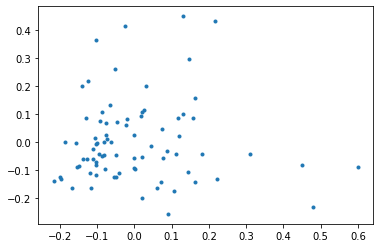

In [179]:
from sklearn.decomposition import PCA
pca = PCA(2)
coordinates = pca.fit_transform(counts)
plt.plot(coordinates[:,0], coordinates[:,1], '.')

/home/marslast/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


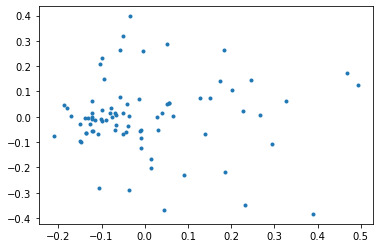

## Task 4
The next thing to do is to try and cluster the songs together according to their count vectors. You can use any algorithm you like, but I recommend $k$-means. For now, just pick an arbitrary number of clusters (I used 4), but make sure you can cluster the data. Take a look at the songs inside a cluster and see if you think they have any similarities. (4 marks)

In [211]:
from sklearn.cluster import KMeans

KMeans = KMeans(n_clusters=4, random_state = 0).fit(counts)
KMeans_t = KMeans.transform(counts)
KMeans_pred = KMeans.predict(counts)
KMeans.cluster_centers_
KMeans_t[:5]

array([[1.04421806, 0.96437417, 0.99165601, 1.04139943],
       [1.06498002, 1.02472818, 0.98521786, 1.07322604],
       [1.05990539, 0.97241998, 1.00850221, 1.0710602 ],
       [1.05308552, 1.01178263, 0.97158571, 1.07023396],
       [1.04834623, 1.01384256, 0.97033197, 1.0407027 ]])

KMeans(algorithm='full', n_clusters=4, random_state=1)

We need to do some more work to work out how many clusters there are. To do this we will take is to see which words are the most common in each cluster. If the cluster is good, then we would expect to see quite a few words in common between the songs in the cluster. There is a function below (`get_top_features_cluster`) that finds them if you give it predictions make by the $k$-means algorithm and the number of words you want. 

## Task 5
Work out how to use the algorithm on the output from $k$-means, and then plot the bar charts for the different clusters. (`df.plot.bar()` will plot things from a Pandas dataframe). You should also use the PCA data and plot the points in different colours according to the clusters kmeans has found. Use both of these resources to decide how many clusters there are in the data.Explain your answer. (7 marks)

In [226]:
def get_top_features_cluster(counts, prediction, nfeatures):
    labels = np.unique(prediction)
    df1 = []
    for label in labels:
        inds = np.where(prediction==label) 
        means = np.mean(counts[inds], axis = 0) 
        sorted_means = np.argsort(means)[::-1][:nfeatures] 
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], means[i]) for i in sorted_means]
        newdf = pd.DataFrame(best_features, columns = ['features', 'score'])
        df1.append(newdf)
    return df1

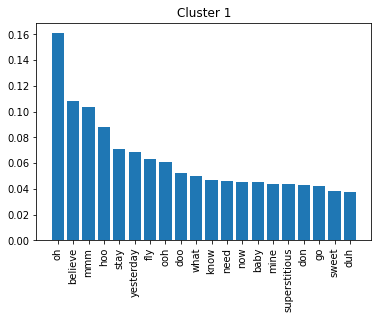

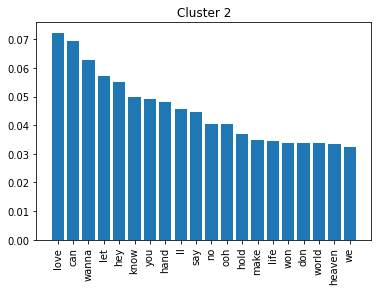

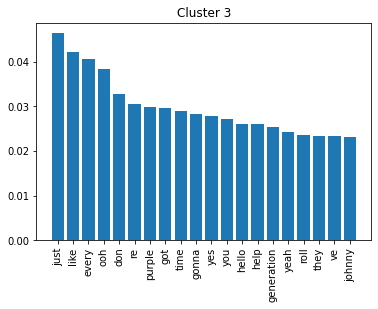

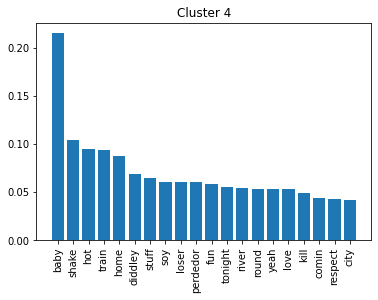

In [225]:
df1 = get_top_features_cluster(counts, KMeans_pred, 20)
for i in range(4):
    plt.figure()
    plt.bar(df1[i]["features"], df1[i]["score"])
    plt.title("Cluster " + str(i+1))
    plt.xticks(rotation=90)
    plt.show()

/home/marslast/miniconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


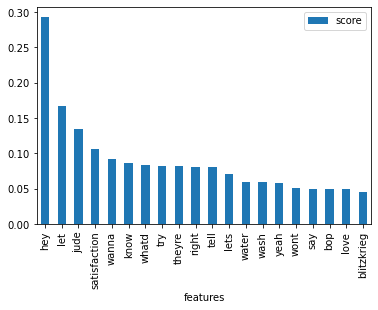

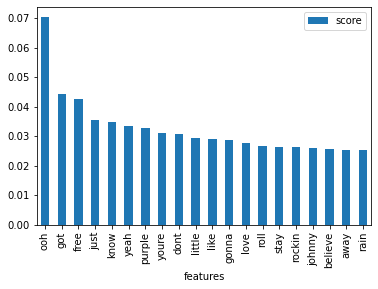

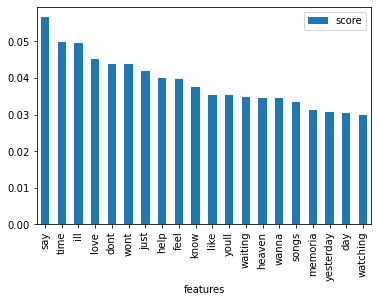

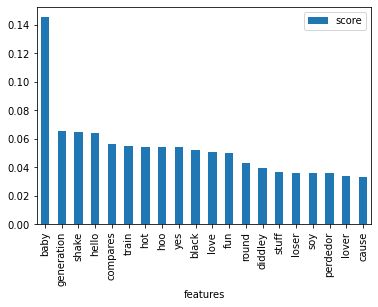

## Task 6
Repeat this analysis on the dataset of national anthems that is available on Blackboard as `anthems.csv` and comment on the differences in words and clusters. This dataset includes the continent that the country is on. Does using this variable change your clusters? (8 marks)

In [ ]:
data = pd.read_csv("anthems.csv", encoding = 'utf-8')
data.head()

,Country,Alpha-2,Alpha-3,Continent,Anthem
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish..."
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo..."
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ..."
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan..."
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea..."


In [ ]:
data = pd.read_csv('../../Datasets/anthems.csv', encoding='utf-8')

In [ ]:
data.head()

,Country,Alpha-2,Alpha-3,Continent,Anthem
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish..."
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo..."
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ..."
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan..."
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea..."
